# Case Study 3 - Select optimal survey locality
## Description 
Based on a mix of environmental parameters and a set of existing sample sites, select the site that adds the greatest environmental variation to those already sampled. This case study uses a set of environmental parameters for New South Wales and an inital set of ten random locations within the state and then selects an 11th to maximise environmental variability.

## Data Sources
The primary goal for this case study is to demonstrate being able to import a set of environmental values for different sites and then use these to identify a subset that maximises spread across the various environmental dimensions.

This is a simple implementation that uses four environmental attributes imported for all Australia (or a subset like NSW) at a moderate grid scale:

1. Soil water pH (0-5cm) - see https://esoil.io/TERNLandscapes/Public/Pages/SLGA/ProductDetails-SoilAttributes.html
2. Soil organic carbon (0-5cm) - see https://esoil.io/TERNLandscapes/Public/Pages/SLGA/ProductDetails-SoilAttributes.html
3. Annual mean rainfall
4. Annual mean temperature

Notes:
- The first two can be imported directly as layers from SLGA. The others are probably available online in suitable forms at a slightly better grid resolution and can also be imported directly.
- An enhancement to this case study would be to start by importing annual layers (say for the last 5 or 10 years) for each of the weather variables and then generating the mean, maximum and minimum respectively for each pixel across the selected years. These computed results would then be the inputs to the main datacube.
- Latitude and longitude could also be incorporated for use directly as additional variables.

## Overview
1. Generate STAC metadata for layers from predefined configuratiion
2. Load data cube and exclude nodata values
3. Scale all variables to a 0.0-1.0 range
4. Select four layers for comparison (soil organic carbon 0-30 cm, soil pH 0-30 cm, mean annual rainfall, mean annual temperature)
5. Select 10 random points within NSW
6. Generate 10 new layers representing standardised environmental distance between one of the selected points and all other points in NSW
7. For every point in NSW, find the lowest environmental distance to any of the selected points
8. Select the point in NSW that has the highest value for the lowest environmental distance to any selected point - this is the most different point
9. Clean up and save results to RO-Crate


## Generate STAC metadata
Create the STAC catalogue using the configuration files prepared for the datasets 

In [1]:
from concurrent.futures import ProcessPoolExecutor
from stac_generator.factory import StacGeneratorFactory
from stac_generator.core.base import StacSerialiser, StacCollectionConfig
from pathlib import Path 

parent_path = Path(__name__).parents[0]
config_path = parent_path / "config.json"
generated_path = parent_path/"generated"

with ProcessPoolExecutor(max_workers=8) as pool:
    generator = StacGeneratorFactory.get_collection_generator(config_path, StacCollectionConfig(id="Collection"), pool=pool)
    serialiser = StacSerialiser(generator, generated_path.as_posix())
    serialiser()

2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_SOC_0_5
2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_SOC_0_10
2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_SOC_5_15
2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_SOC_15_30
2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_SOC_10_30
2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_SOC_0_30
2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_pH_5_15
2025-05-28T09:36:05-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_pH_0_5
2025-05-28T09:36:07-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_pH_15_30
2025-05-28T09:36:07-stac_generator.core.raster.generator - INFO - Reading raster asset: NSW_p

## Load Data Cube generation
Import the data layers into a 100x100 data cube

In [2]:
from mccn.client import MCCN
import matplotlib.pyplot as plt

engine = MCCN(endpoint=generated_path/"collection.json", shape=100)

all_data = engine.load()

all_data

<xarray.Dataset> Size: 3MB
Dimensions:              (time: 2, y: 100, x: 100)
Coordinates:
  * y                    (y) float64 800B -28.08 -28.17 -28.27 ... -37.33 -37.42
  * x                    (x) float64 800B 141.0 141.1 141.2 ... 153.5 153.6
    spatial_ref          int32 4B 4326
  * time                 (time) datetime64[ns] 16B 2009-12-30T13:00:00 2022-0...
Data variables: (12/17)
    soc_0_5_mean         (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    soc_5_15_mean        (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    soc_15_30_mean       (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    soc_0_10_mean        (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    soc_10_30_mean       (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    soc_0_30_mean        (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    ...                   ...
    ph_100_200_mean      (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    ph_0_10_mean         (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    ph_10_30_mean        (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    ph_0_30_mean         (time, y, x) float64 160kB 0.0 0.0 ... -3.4e+38
    rainfall_mm          (time, y, x) float64 160kB -3.403e+38 ... 0.0
    temperature_celsius  (time, y, x) float64 160kB -3.403e+38 ... 0.0

## Prepare data
Filter out nodata values from the float32 layers. Then scale all variables to a 0.0 to 1.0 range.

In [3]:
import numpy as np

filtered = all_data.where((all_data > -1e3),np.nan)

scaled_data = filtered.copy()

# Scale each variable to 0-1 range
for var in scaled_data.data_vars:
    # Get min and max for the current variable
    var_min = float(scaled_data[var].min())
    var_max = float(scaled_data[var].max())
    
    # Apply min-max scaling
    scaled_data[var] = (scaled_data[var] - var_min) / (var_max - var_min)

    data = scaled_data[var].values

    # Print the scaling factors for reference
    print(f"Scaling for {var}: Original range: {var_min:.2f} to {var_max:.2f} -> Scaled range: {float(scaled_data[var].min()):.2f} to {float(scaled_data[var].max()):.2f} (Mean: {np.nanmean(data):.4f})")

Scaling for soc_0_5_mean: Original range: 0.00 to 64.10 -> Scaled range: 0.00 to 1.00 (Mean: 0.1225)
Scaling for soc_5_15_mean: Original range: 0.00 to 52.70 -> Scaled range: 0.00 to 1.00 (Mean: 0.1164)
Scaling for soc_15_30_mean: Original range: 0.00 to 37.90 -> Scaled range: 0.00 to 1.00 (Mean: 0.1114)
Scaling for soc_0_10_mean: Original range: 0.00 to 59.70 -> Scaled range: 0.00 to 1.00 (Mean: 0.1297)
Scaling for soc_10_30_mean: Original range: 0.00 to 39.90 -> Scaled range: 0.00 to 1.00 (Mean: 0.1099)
Scaling for soc_0_30_mean: Original range: 0.00 to 56.40 -> Scaled range: 0.00 to 1.00 (Mean: 0.1003)
Scaling for ph_0_5_mean: Original range: 0.00 to 7.60 -> Scaled range: 0.00 to 1.00 (Mean: 0.2964)
Scaling for ph_5_15_mean: Original range: 0.00 to 7.70 -> Scaled range: 0.00 to 1.00 (Mean: 0.2945)
Scaling for ph_15_30_mean: Original range: 0.00 to 7.90 -> Scaled range: 0.00 to 1.00 (Mean: 0.2962)
Scaling for ph_30_60_mean: Original range: 0.00 to 8.20 -> Scaled range: 0.00 to 1.00 (

## Display selected layers
Map the scaled values for four selected environmental variables (mean annual temperature, mean annual rainfaill, soil organic carbon at 0-30 cm, soil pH at 0-30 cm)

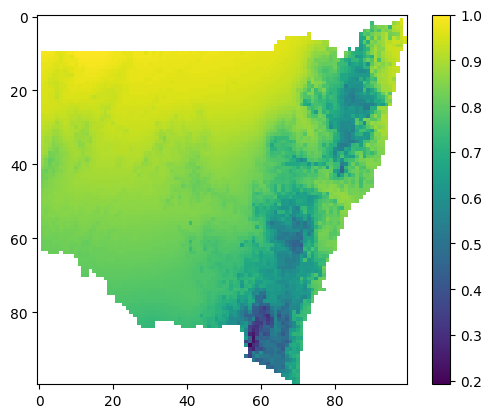

In [4]:
plt.imshow(scaled_data.temperature_celsius.values[0, :, :])
plt.colorbar()
plt.show()

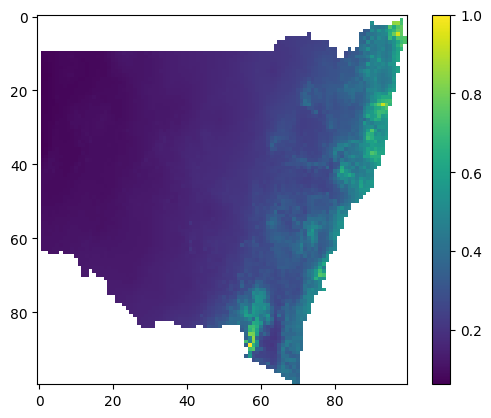

In [5]:
plt.imshow(scaled_data.rainfall_mm.values[0, :, :])
plt.colorbar()
plt.show()

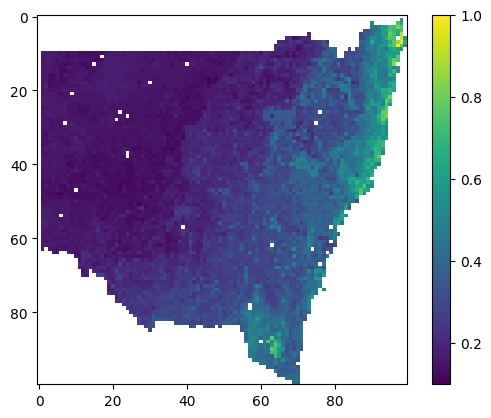

In [6]:
plt.imshow(scaled_data.soc_0_30_mean.values[1, :, :])
plt.colorbar()
plt.show()

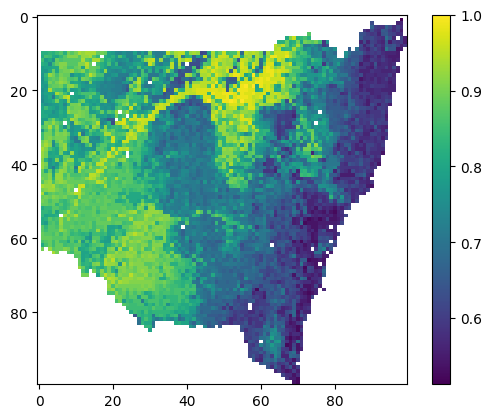

In [7]:
plt.imshow(scaled_data.ph_0_30_mean.values[1, :, :])
plt.colorbar()
plt.show()

## Data Analysis

1. Select 10 random positions across the space selected.
2. Goal is to find the optimal position for an 11th site to maximise variation across the environment.
3. Scale all environmental layers on a 0.0 to 1.0 scale based on the actual range of values in the layer.
4. Treat these layer values as orthogonal axes in a 5-dimensional space. The environmental distance between any two points will be the fifth root of the product of these five numbers.
5. Generate 10 new layers, each representing the environmental distance between every pixel and one of the 10 current points.
6. Build a new layer that holds the smallest value for each pixel from these 10 layers - that is the environmental distance between that point and the environmentally closest of the 10 current points.
7. Find which pixel has the highest value in this final layer - it represents the most environmentally distant point and the one that should next be surveyed.

### Find pixels with valies in selected layers

In [8]:
# Method to calculate environmental distance in 4D environmental space
def environmental_distance(point_values, layer_values):
    differences = np.abs(point_values - layer_values)
    return np.power(np.prod(differences, axis=-1), 1/4)

selected_layers = [
    scaled_data.soc_0_30_mean.values[1], 
    scaled_data.ph_0_30_mean.values[1],
    scaled_data.rainfall_mm.values[0],
    scaled_data.temperature_celsius.values[0]
]

layer_values = np.stack(selected_layers, axis=-1)

# Stack layers into a single array
layer_values = np.stack(selected_layers, axis=-1)

# Create valid mask (where we have data for all layers)
# Exclude both NaN and zero values for SOC and pH (indices 0 and 1)
valid_mask = (
    ~np.any(np.isnan(layer_values), axis=-1) &  # No NaN values
    (layer_values[..., 0] > 0) &                # SOC > 0
    (layer_values[..., 1] > 0)                  # pH > 0
)

valid_indices = np.where(valid_mask)
valid_positions_all = list(zip(valid_indices[0], valid_indices[1]))

n_valid = len(valid_positions_all)
print(f"Found {n_valid} valid positions in the data")

Found 6343 valid positions in the data


### Find 10 random pixels and then an 11th pixel where the environment is most different

In [14]:
import random
import warnings

if n_valid == 0:
    print("Error: No valid positions found. Check your data for NaN values.")
else:
    # Use all valid positions if less than 10, otherwise sample 10
    n_samples = min(n_valid, 10)
    valid_positions = random.sample(valid_positions_all, n_samples)
    
    print(f"\nUsing {n_samples} sampling positions:")

    # Calculate distance layers for each point
    distance_layers = []
    for pos in valid_positions:
        point_values = layer_values[pos[0], pos[1]]
        distances = environmental_distance(point_values, layer_values)
        distance_layers.append(distances)

    # Build minimum distance layer
    with warnings.catch_warnings():
        # A warning will be generated for pixels without values
        warnings.simplefilter("ignore", category=RuntimeWarning)
        distance_layers = np.stack(distance_layers, axis=0)
        min_distances = np.nanmin(distance_layers, axis=0)

    # Find highest value pixel
    min_distances[~valid_mask] = np.nan  # Ensure we don't select invalid positions
    optimal_position = np.unravel_index(np.nanargmax(min_distances), min_distances.shape)
    max_min_distance = min_distances[optimal_position]

    for i, pos in enumerate(valid_positions, 1):
        values = layer_values[pos[0], pos[1]]
        print(f"  Point {i}: Row: {pos[0]}, Col: {pos[1]} ",
              f"SOC: {values[0]:.3f}, pH: {values[1]:.3f}, "
              f"Rainfall: {values[2]:.3f}, Temp: {values[3]:.3f}")

    opt_values = layer_values[optimal_position[0], optimal_position[1]]
    print(f"Optimal new sampling location: ",
          f"Row: {optimal_position[0]}, Col: {optimal_position[1]} ",
          f"SOC: {opt_values[0]:.3f}, pH: {opt_values[1]:.3f}, "
          f"Rainfall: {opt_values[2]:.3f}, Temp: {opt_values[3]:.3f}")
    print(f"Environmental distance score for new location: {max_min_distance:.5f}")


Using 10 sampling positions:
  Point 1: Row: 27, Col: 48  SOC: 0.184, pH: 0.910, Rainfall: 0.159, Temp: 0.927
  Point 2: Row: 25, Col: 11  SOC: 0.126, pH: 0.897, Rainfall: 0.091, Temp: 0.934
  Point 3: Row: 75, Col: 42  SOC: 0.254, pH: 0.833, Rainfall: 0.175, Temp: 0.782
  Point 4: Row: 59, Col: 58  SOC: 0.305, pH: 0.667, Rainfall: 0.254, Temp: 0.772
  Point 5: Row: 50, Col: 80  SOC: 0.355, pH: 0.590, Rainfall: 0.379, Temp: 0.744
  Point 6: Row: 17, Col: 94  SOC: 0.489, pH: 0.603, Rainfall: 0.431, Temp: 0.898
  Point 7: Row: 10, Col: 73  SOC: 0.213, pH: 0.769, Rainfall: 0.247, Temp: 0.900
  Point 8: Row: 12, Col: 40  SOC: 0.137, pH: 0.962, Rainfall: 0.148, Temp: 0.975
  Point 9: Row: 92, Col: 67  SOC: 0.372, pH: 0.564, Rainfall: 0.395, Temp: 0.579
  Point 10: Row: 56, Col: 20  SOC: 0.156, pH: 0.872, Rainfall: 0.109, Temp: 0.846
Optimal new sampling location:  Row: 89, Col: 65  SOC: 0.676, pH: 0.718, Rainfall: 0.305, Temp: 0.440
Environmental distance score for new location: 0.13353


## Map environmental distance of sample points to rest of NSW
For each of the 10 sample points, display the location on a map and colour NSW according to the similarity/distance of each point to the sample point.

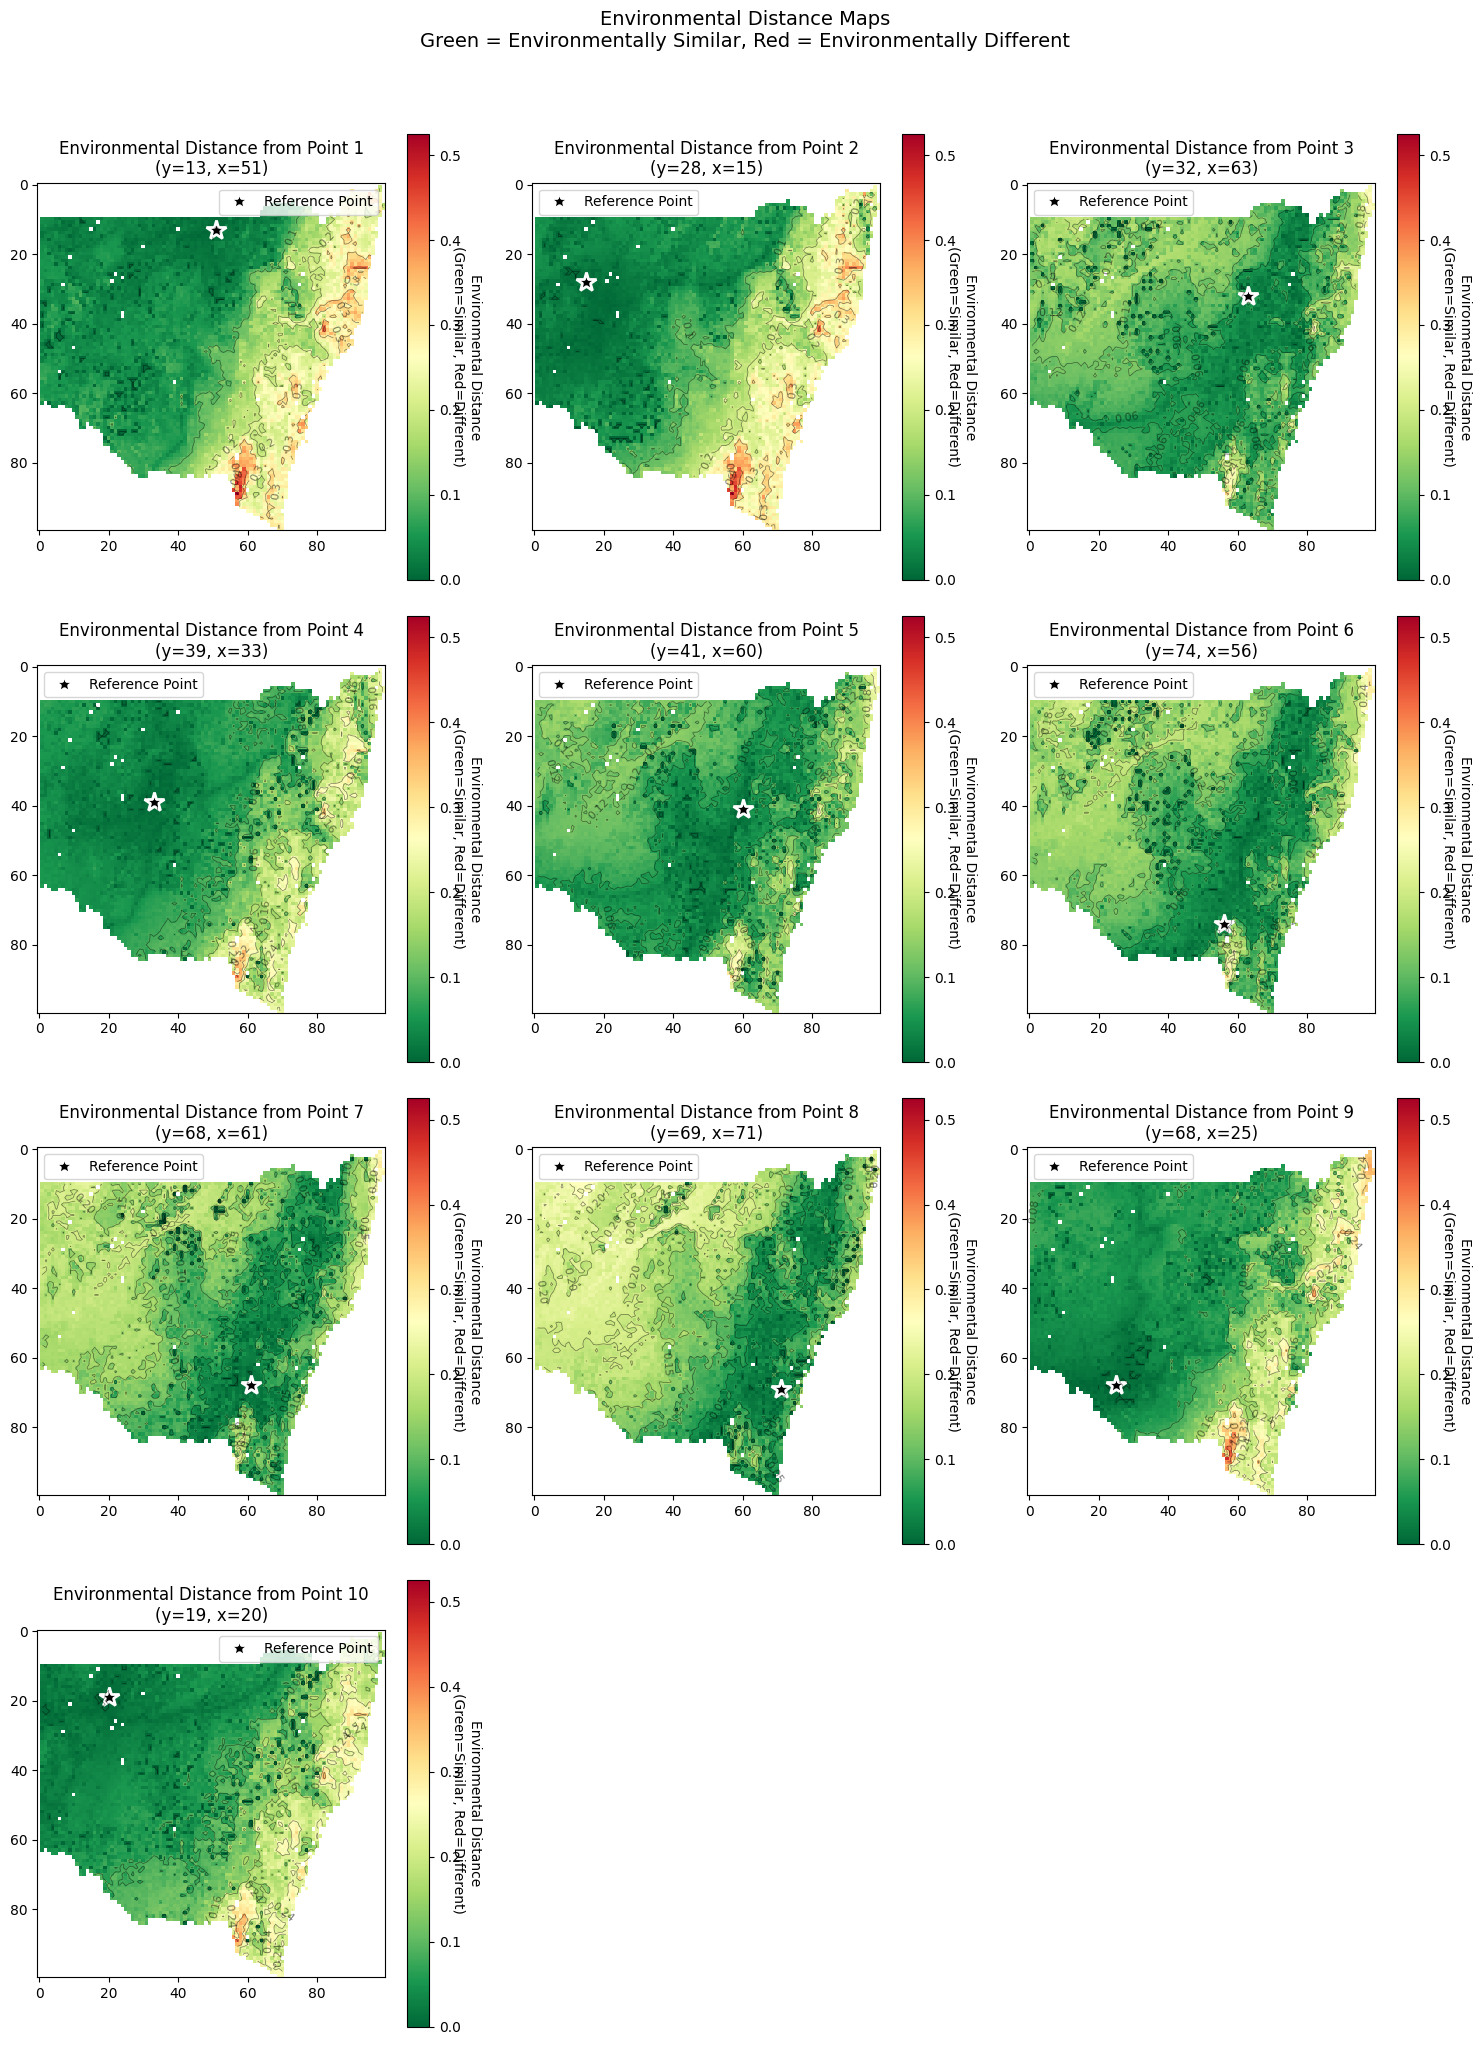

In [10]:
n_points = len(valid_positions)
n_cols = min(3, n_points)
n_rows = int(np.ceil(n_points / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = np.array(axes).ravel()  # Convert to 1D array for easier indexing

# Create a custom colormap
custom_cmap = plt.cm.RdYlGn_r

for idx, distance_layer in enumerate(distance_layers):
    # Plot each distance layer
    im = axes[idx].imshow(distance_layer, 
                         cmap=custom_cmap,
                         vmin=0,
                         vmax=np.nanmax(distance_layers))
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx])
    cbar.set_label('Environmental Distance\n(Green=Similar, Red=Different)', 
                   rotation=270, labelpad=15)
    
    # Mark the reference point
    axes[idx].plot(valid_positions[idx][1], valid_positions[idx][0], 
                  'k*', markersize=15, markeredgecolor='white', markeredgewidth=2,
                  label='Reference Point')
    
    # Add contours
    contours = axes[idx].contour(distance_layer, 
                                levels=5,
                                colors='black',
                                alpha=0.5,
                                linewidths=0.5)
    axes[idx].clabel(contours, inline=True, fontsize=8)
    
    axes[idx].set_title(f'Environmental Distance from Point {idx+1}\n(y={valid_positions[idx][0]}, x={valid_positions[idx][1]})')
    axes[idx].legend()

# Hide any unused subplots
for idx in range(n_points, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Environmental Distance Maps\nGreen = Environmentally Similar, Red = Environmentally Different', 
             size=14, y=1.02)
plt.tight_layout()
plt.show()

## Map the environmental distance for the selected point
Map the environmental distance between each point and the environmentally closest sample point, and show the location of the newly selected point.

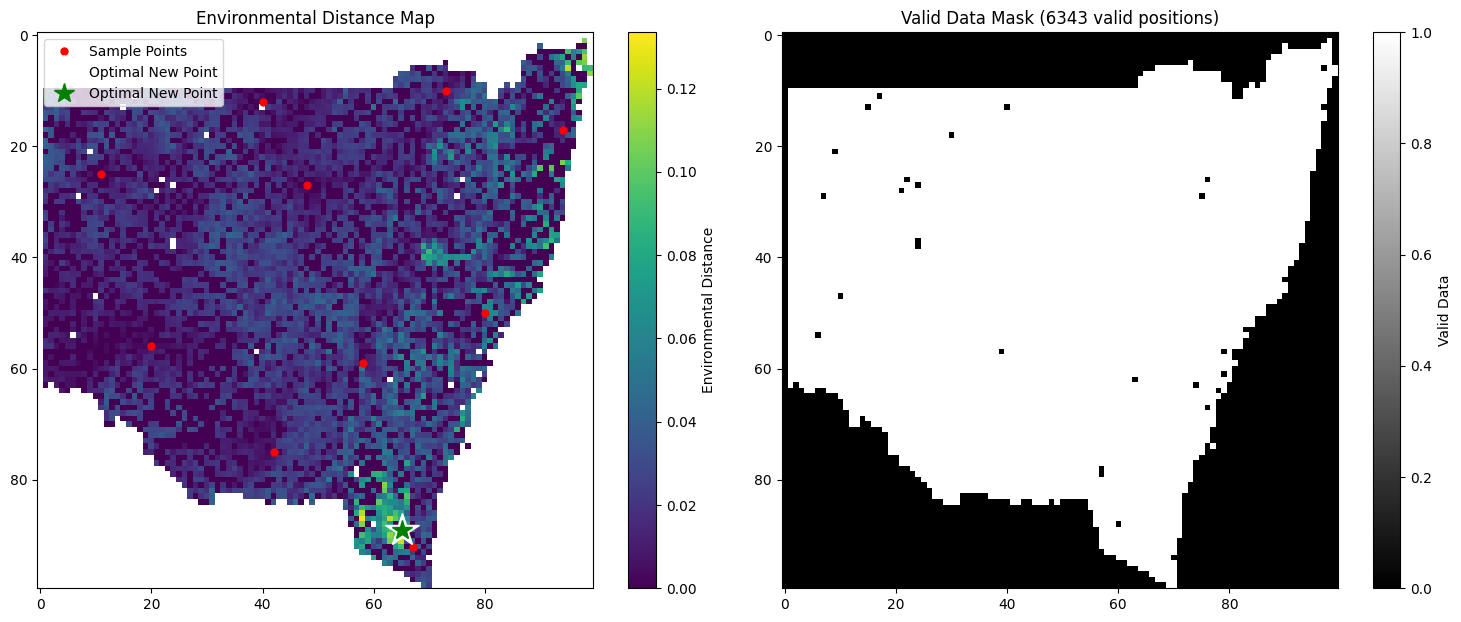

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot distance map
masked_distances = np.ma.masked_array(min_distances, ~valid_mask)
im1 = ax1.imshow(masked_distances, cmap='viridis')
plt.colorbar(im1, ax=ax1, label='Environmental Distance')

ax1.plot([p[1] for p in valid_positions], [p[0] for p in valid_positions], 'r.', 
         markersize=10, label='Sample Points')

ax1.plot(optimal_position[1], optimal_position[0], 'w*', 
         markersize=25, label='Optimal New Point')
ax1.plot(optimal_position[1], optimal_position[0], 'g*', 
         markersize=15, label='Optimal New Point')

ax1.legend()
ax1.set_title('Environmental Distance Map')

im2 = ax2.imshow(valid_mask, cmap='gray')
plt.colorbar(im2, ax=ax2, label='Valid Data')
ax2.set_title(f'Valid Data Mask ({n_valid} valid positions)')

plt.tight_layout()
plt.show()

### Cleanup and remove the generated folder

In [12]:
import shutil 

shutil.rmtree(generated_path)